# Import Libraries

In [75]:
# import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import Data preprocessing tools
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# import tools for modelling
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input

# other libraries
import warnings

# global settings
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('viridis')

# Get the Data and Check whether it's clean

In [22]:
# import the data
raw_data = pd.read_csv('insurance.csv')

# create a copy and work with it
insurance_df = raw_data.copy()

In [23]:
# read a sample of the data
insurance_df.sample(10)

,age,sex,bmi,children,smoker,region,charges
83,48,female,41.230,4,no,northwest,11033.66170
1288,20,male,39.400,2,yes,southwest,38344.56600
430,19,male,33.100,0,no,southwest,23082.95533
646,39,male,26.220,1,no,northwest,6123.56880
450,39,male,29.600,4,no,southwest,7512.26700
2,28,male,33.000,3,no,southeast,4449.46200
577,31,female,38.095,1,yes,northeast,58571.07448
85,45,male,22.895,2,yes,northwest,21098.55405
475,61,male,28.310,1,yes,northwest,28868.66390
1209,59,male,37.100,1,no,southwest,12347.17200


In [24]:
# check for duplcates
insurance_df.loc[insurance_df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


There is one instance of a duplicated row but we will not drop that row since <br> it is possible to have two different individuals from the same region with same age, bmi, and the charges for that person

In [5]:
# check null values
insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Exploratory Analysis

In [6]:
# check for information about the dataset
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# Get the descriptive on both categorical and numerical data
descr = insurance_df.describe()
descr.transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
# get the statistics for categorical variables too
cat_desc = insurance_df.describe(exclude=['int64','float64'])
cat_desc.transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


## Visualizing our columns

### Univariate analysis

In [9]:
# extracting categorical and numerical variables
cat_cols = insurance_df.select_dtypes('object')
num_cols = insurance_df.select_dtypes(['int64','float64'])

In [28]:
# creating a function to plot both numerical and categorical variables
def plot_variables(cols, row, data, data_type, fig_size=(10,8)):
    """
    This function Takes the data to be plotted, the number or rows and columns on the chart
    and plots with a default fig_size
    """
    fig, axes = plt.subplots(ncols=cols, nrows=row, figsize=fig_size)
    axes = axes.flatten()
    
    # create a loop to iterate over the categorical columns and plot them
    for i, col in enumerate(data):
        ax = axes[i]
        if data_type=='object':
            sns.countplot(data=data, x=col, ax=ax).set(title=f"A CountPlot of {col}")
        else:
            sns.histplot(data=data, x=col, ax=ax).set(title=f"A Distribution of {col}")
    plt.tight_layout()

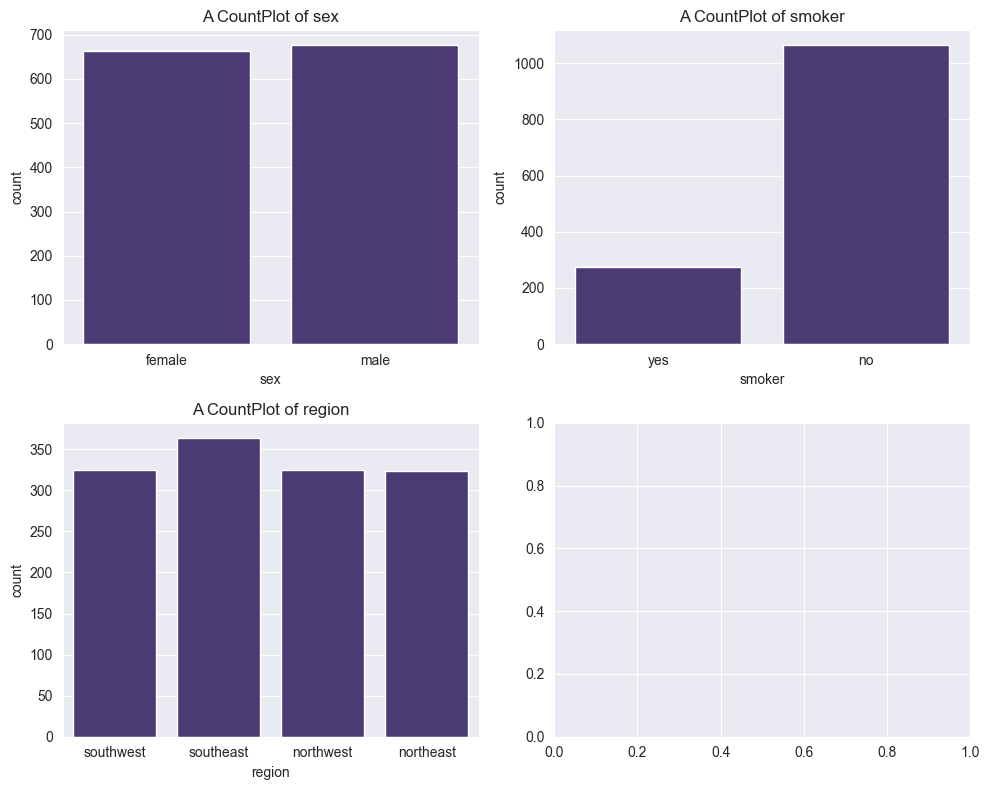

In [31]:
# Plotting all categorical variables
plot_variables(2,2,cat_cols, 'object')

From Our charts above, we can observe that there seem to be a fair distribution across various variables. It's only the Smoker column that we tend to have more individuals who do not smoke as compared to those who smoke

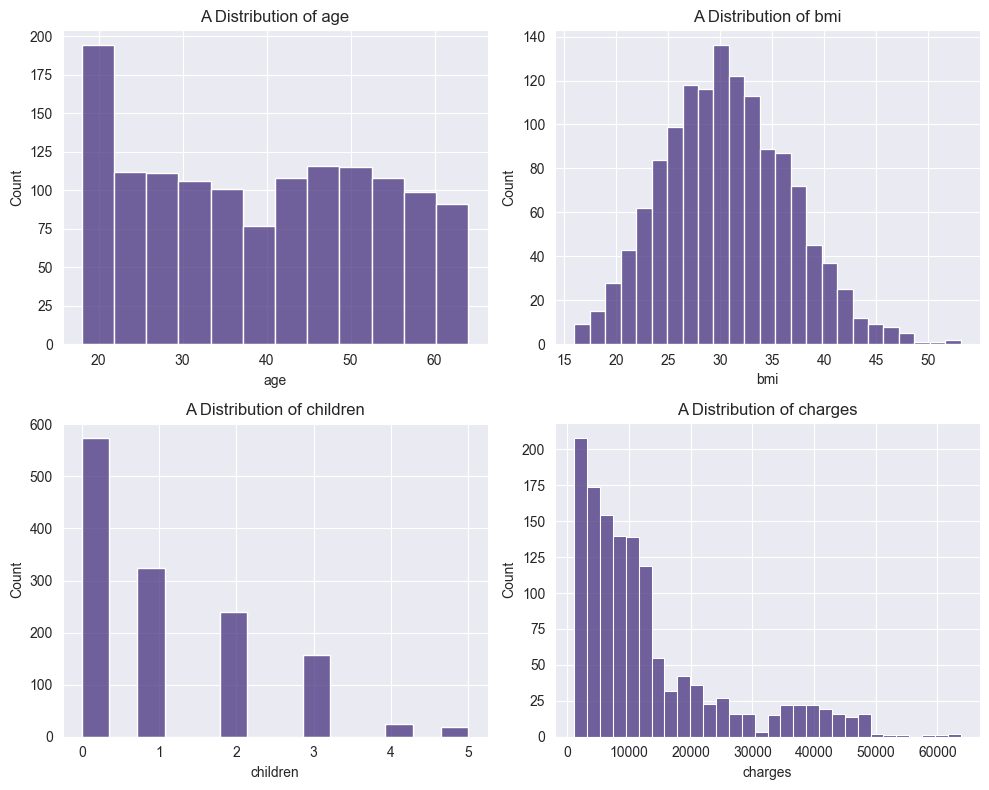

In [32]:
# plot the numerical columns
plot_variables(2,2, num_cols, 'int64')

The visualizations depict the distributions of age, BMI (Body Mass Index), number of children, and insurance charges within the dataset. The age range spans from 20 to 65 years, with the majority concentrated between 20 and 25 years. The BMI values follow a bell-shaped, normal distribution, peaking around 30 kg/m² and primarily falling between 25 and 35 kg/m². Most individuals have no children, and the number of individuals decreases as the number of children increases, with very few having more than three children. Insurance charges are right-skewed, indicating most individuals incur lower charges, predominantly below $10,000, with a few high-cost outliers extending up to $60,000. These distributions suggest a predominantly young population with healthy to slightly overweight BMI, few children, and generally low insurance costs with some expensive cases.

### Multivariate analysis

In [13]:
# Performing a Pearson's correlation to know which columns have high relationship with the target(charges)
corr = num_cols.corr()
corr['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

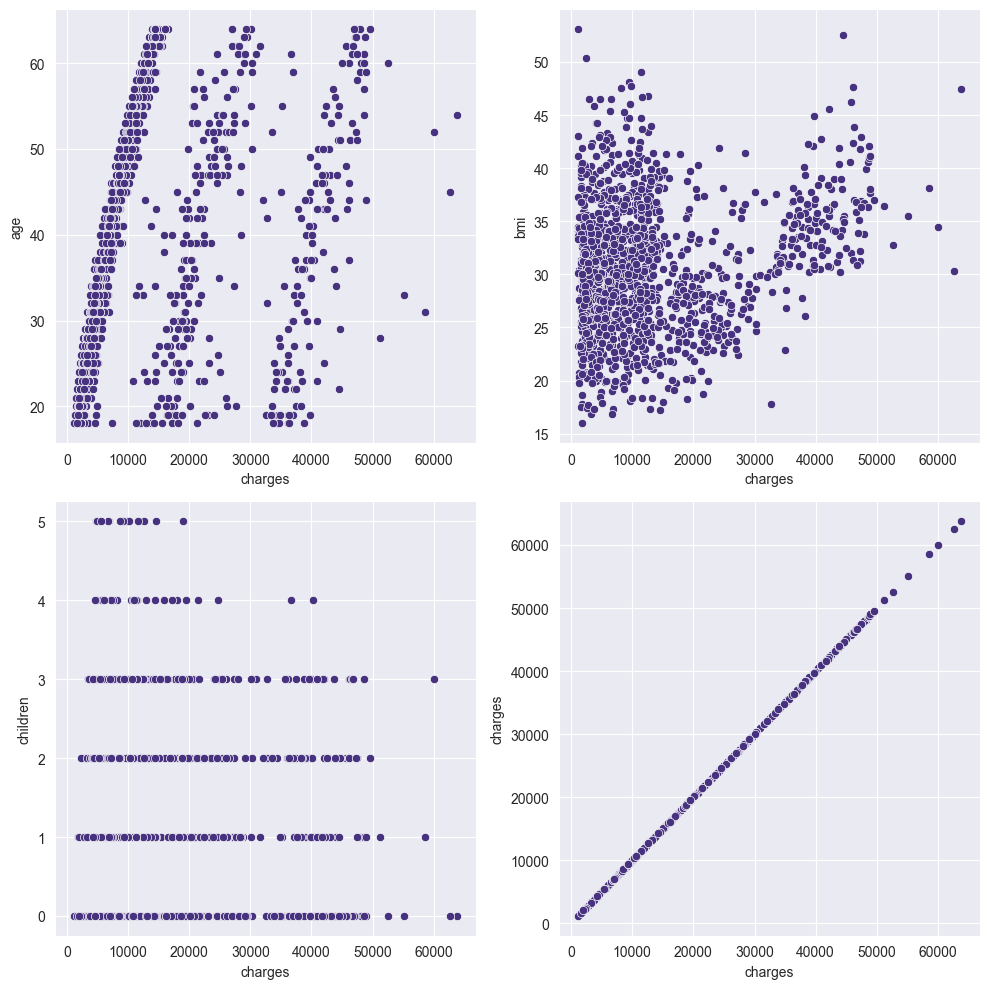

In [33]:
# drawing scatterplots to visualize relationshipes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.scatterplot(data=num_cols, x='charges', y=col, ax=ax)
plt.tight_layout()

The scatter plots illustrate relationships between insurance charges and four variables: age, BMI, number of children, and charges (self-referential to check plotting consistency). The first plot (top left) shows that insurance charges generally increase with age, suggesting older individuals tend to incur higher charges. The second plot (top right) reveals no clear linear relationship between BMI and charges, although higher charges seem more dispersed at higher BMI levels. The third plot (bottom left) indicates no significant trend between the number of children and charges, as the data points are widely scattered across different charge levels regardless of the number of children. The fourth plot (bottom right) serves as a reference, confirming that charges are plotted correctly against themselves, forming a perfect diagonal line. Overall, these plots highlight that age has a noticeable correlation with insurance charges, while BMI and the number of children do not exhibit a strong direct relationship with charges.

C:\Users\HP\AppData\Local\Temp\ipykernel_2392\2318974307.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_df, x=col, y='charges', ax=ax, palette='viridis').set(title=f"A Bar Plot of {col}")
C:\Users\HP\AppData\Local\Temp\ipykernel_2392\2318974307.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_df, x=col, y='charges', ax=ax, palette='viridis').set(title=f"A Bar Plot of {col}")
C:\Users\HP\AppData\Local\Temp\ipykernel_2392\2318974307.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insurance_df, x=c

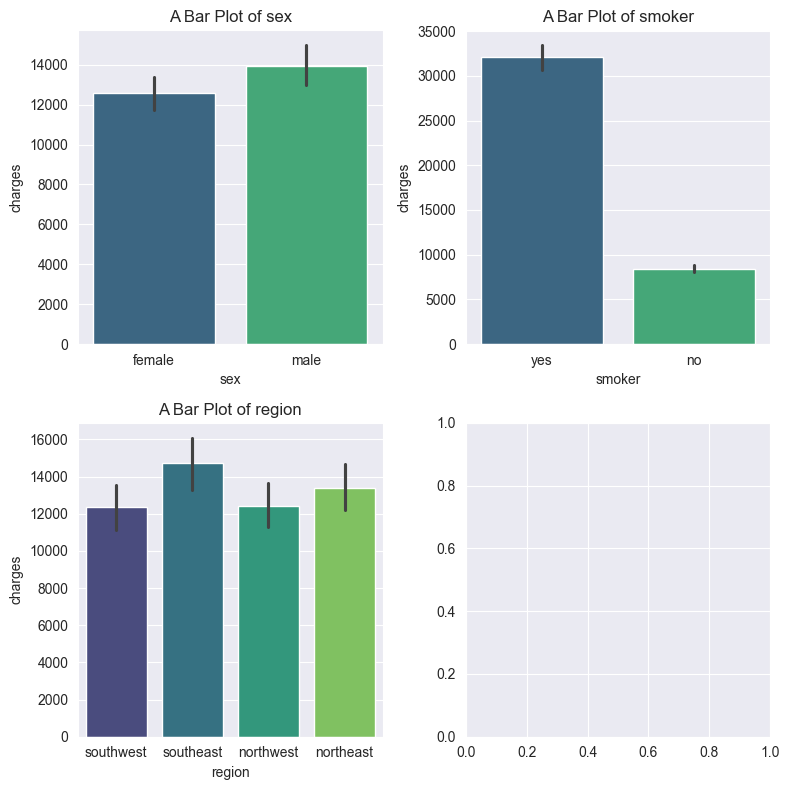

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axes = axes.flatten()

# create a loop to iterate over the categorical columns and plot them
for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.barplot(data=insurance_df, x=col, y='charges', ax=ax, palette='viridis').set(title=f"A Bar Plot of {col}")
plt.tight_layout()

# Data Preprocessing

In [53]:
# Creating an instance of a transformer
ct = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (MinMaxScaler(), ['age', 'bmi', 'children'])
)

In [55]:
# split data into training and testing set
X = insurance_df.drop('charges', axis=1)
y = insurance_df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Now transform the data
X_train_transf = ct.fit_transform(X_train)
X_test_transf = ct.transform(X_test)

# Modeling
1. Create a model
2. Compile the model
3. fit the model
4. Evaluate on the test set
5. Get metrics and store them
6. Repeat process till we get a model with a very good metric

## Model_1
a model with one hidden layer with 50 neurons (activation relu)
Adam as the the optimizer and a learning rate of 0.1

In [65]:
# set a random seed
tf.random.set_seed(42)
# create the model
model_1 = Sequential([
    Dense(50, name='hidden_layer', activation='relu'),
    Dense(1, name='output_layer')
], name='model_1')

# compile the model
model_1.compile(
    loss='mae',
    optimizer=optimizers.Adam(learning_rate=0.1),
    metrics = ['mae', 'mse']
)

history = model_1.fit(X_train_transf, y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=0)
# Get summary from the model
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,955 (7.64 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,304 (5.10 KB)

In [66]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2776.3540 - mae: 2776.3540 - mse: 37478968.0000 


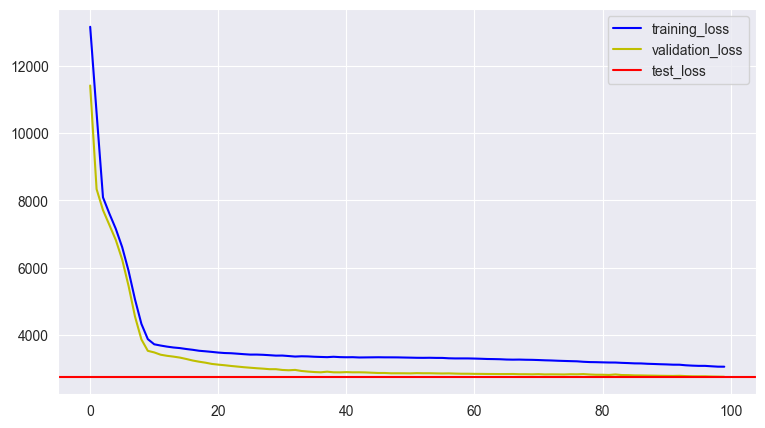

In [78]:
# Evaluate the model on the testing set and get the metrics
results = model_1.evaluate(X_test_transf, y_test)[0]
loss = history.history['loss']
val_los = history.history['val_loss']

# lets plot the training and validation losses
def plot_model_perfomance(epochs, train_loss, val_loss, test_loss):
    epochs_range = range(epochs)
    plt.figure(figsize=(9,5))
    plt.plot(epochs_range, train_loss, c='b', label='training_loss')
    plt.plot(epochs_range, val_loss, c='y', label='validation_loss')
    plt.axhline(test_loss, c='r', label='test_loss')
    plt.legend()

# plot
plot_model_perfomance(100, loss, val_los, results)

In [90]:
# make predictions
y_pred_1 = model_1.predict(X_test_transf)
# get metrics
mae_1 = metrics.mae(y_test, tf.squeeze(y_pred_1))
mse_1 = metrics.mse(y_test, tf.squeeze(y_pred_1))
mae_1, mse_1

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(<tf.Tensor: shape=(), dtype=float32, numpy=2756.1787>,
 <tf.Tensor: shape=(), dtype=float32, numpy=38128104.0>)

## model 2
a model with 4 hidden layers with 100, 50, 10 neurons (activation relu) Adam as the the optimizer and a learning rate of 0.1

In [79]:
# build the model
model_2 = Sequential([
    Input(shape=[11]),
    Dense(100, activation='relu', name='hidden_layer_1'),
    Dense(50, activation = 'relu', name='hidden_layer_2'),
    Dense(10, activation='relu', name='hidden_layer_3'),
    Dense(1, name='output')
])

# compile the model
model_2.compile(
    loss='mae',
    optimizer = optimizers.Adam(learning_rate=0.1),
    metrics = ['mae', 'mse']
)

# fit the model
history = model_2.fit(X_train_transf, y_train, validation_split=0.2, epochs=200, batch_size=32, verbose=0)

# get a summary of the model
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100)            │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,315 (79.36 KB)

 Trainable params: 6,771 (26.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,544 (52.91 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1729.2675 - mae: 1729.2675 - mse: 19230162.0000 
Training Loss: 1887.1361083984375
Validation Loss: 1977.6890869140625
Test Loss: 1827.37255859375


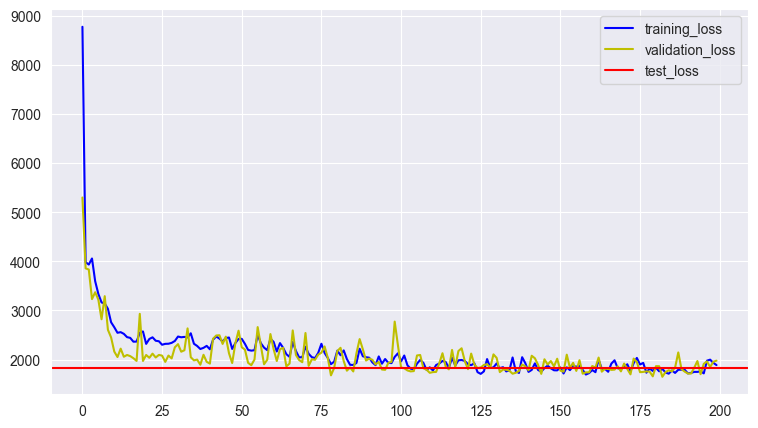

In [85]:
# get training, validation and testing losses
t_loss = history.history['loss']
v_loss = history.history['val_loss']
test = model_2.evaluate(X_test_transf, y_test)[0]

# plot
plot_model_perfomance(200, t_loss, v_loss, test)

print(f"Training Loss: {t_loss[-1]}")
print(f"Validation Loss: {v_loss[-1]}")
print(f"Test Loss: {test}")

In [91]:
# make predictions
y_pred_2 = model_2.predict(X_test_transf)
# get metrics
mae_2 = metrics.mae(y_test, tf.squeeze(y_pred_2))
mse_2 = metrics.mse(y_test, tf.squeeze(y_pred_2))

mae_2, mse_2

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(<tf.Tensor: shape=(), dtype=float32, numpy=1827.3724>,
 <tf.Tensor: shape=(), dtype=float32, numpy=21528174.0>)

## Model 3
4 hidden layers, 150, 100, 50, 10, activation function is relu, learning rate 0.1, train for 400

In [94]:
# build the model
model_3 = Sequential([
    Input(shape=[11]),
    Dense(150, activation='relu', name='hidden_layer_1'),
    Dense(100, activation='relu', name='hidden_layer_2'),
    Dense(50, activation = 'relu', name='hidden_layer_3'),
    Dense(10, activation='relu', name='hidden_layer_4'),
    Dense(1, name='output')
], name='model_3')

# compile the model
model_3.compile(
    loss='mae',
    optimizer = optimizers.Adam(learning_rate=0.1),
    metrics = ['mae', 'mse']
)

# fit the model
history = model_3.fit(X_train_transf, y_train, validation_split=0.2, epochs=400, batch_size=42, verbose=0)

# get a summary of the model
model_3.summary()

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 150)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,415 (263.34 KB)

 Trainable params: 22,471 (87.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,944 (175.57 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1541.7759 - mae: 1541.7759 - mse: 19206270.0000
Training Loss: 1595.1947021484375
Validation Loss: 1767.0667724609375
Test Loss: 1679.0882568359375


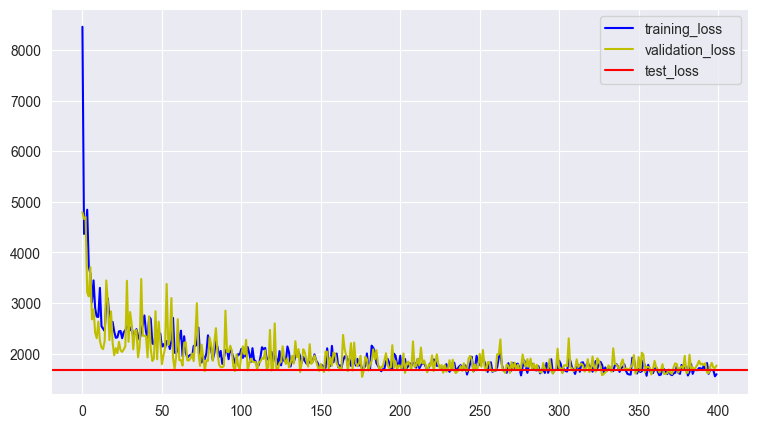

In [95]:
# get training, validation and testing losses
t_loss = history.history['loss']
v_loss = history.history['val_loss']
test = model_3.evaluate(X_test_transf, y_test)[0]

# plot
plot_model_perfomance(400, t_loss, v_loss, test)

print(f"Training Loss: {t_loss[-1]}")
print(f"Validation Loss: {v_loss[-1]}")
print(f"Test Loss: {test}")

In [96]:
# make predictions
y_pred_3 = model_3.predict(X_test_transf)
# get metrics
mae_3 = metrics.mae(y_test, tf.squeeze(y_pred_3))
mse_3 = metrics.mse(y_test, tf.squeeze(y_pred_3))

mae_3, mse_3

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


(<tf.Tensor: shape=(), dtype=float32, numpy=1679.0881>,
 <tf.Tensor: shape=(), dtype=float32, numpy=21915888.0>)

In [97]:
# Let's create a dataframe for the metrics and select the best model
metrics = [
    ['model_1', mae_1.numpy, mse_1.numpy],
    ['model_1', mae_2, mse_2],
    ['model_3', mae_3, mse_3]
]

pd.DataFrame(metrics, columns=['model', 'mae', 'mse'])

,model,mae,mse
0,model_1,"tf.Tensor(2756.1787, shape=(), dtype=float32)","tf.Tensor(38128104.0, shape=(), dtype=float32)"
1,model_1,"tf.Tensor(1827.3724, shape=(), dtype=float32)","tf.Tensor(21528174.0, shape=(), dtype=float32)"
2,model_3,"tf.Tensor(1679.0881, shape=(), dtype=float32)","tf.Tensor(21915888.0, shape=(), dtype=float32)"
